In [21]:
#ignore
%cd '/Users/renewang/Documents/workspace/Kaggle/symlearn/'
%load_ext rpy2.ipython
%matplotlib inline

In [22]:
#ignore
from sklearn.cross_validation import KFold, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
from recursnn.recursnn_train import MovieRatingTrainer
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pylab as plt

def prepare_data(sentiments, kfold_cv, skfold_cv, cv_strategy, cv_num):
    #shape: number_of_sentence x num_of_cv_strategy x cv_num
    cv_frame = np.zeros((sentiments.shape[0], cv_strategy, cv_num));
    columns = ['Sentiment'];
    columns.extend(list('kfold' for i in range(cv_num)));
    columns.extend(list('skfold' for i in range(cv_num)));

    for i, ((ktrain, ktest), (sktrain, sktest)) in enumerate(zip(kfold_cv, skfold_cv)):
        cv_frame[ktest, 0, i] = i+1;
        cv_frame[sktest, 1, i] = i+1;

    sentcv_df = pd.DataFrame(np.hstack((sentiments.reshape(sentiments.shape[0],1), 
                             cv_frame.reshape(sentiments.shape[0], cv_strategy*cv_num))), columns = columns);
    sentcv_df = pd.melt(sentcv_df, id_vars='Sentiment', var_name='strategy');
    compiled_list = [sentcv_df[sentcv_df['value']==i+1].groupby(
            ['strategy', 'Sentiment']).count() for i in range(cv_num)];
    sent_dist = pd.melt(pd.concat(compiled_list, axis = 1, names = range(cv_num), 
                                  ignore_index = True).reset_index(), 
                        id_vars=['strategy', 'Sentiment'], var_name = 'fold_num');
    sent_dist.fillna(value = 0.0, inplace=True);
    # check nan
    assert(sent_dist['value'].isnull().any() == False);
    ttl_sum = sent_dist.groupby(['fold_num','strategy'])['value'].sum().reset_index();
    ttl_sum.columns = ['fold_num', 'strategy', 'total'];
    sent_dist = sent_dist.merge(ttl_sum, on =['fold_num','strategy']);
    sent_dist['value']= sent_dist['value']/sent_dist['total'];
    return(sent_dist);

num_of_classes = 5;
cv_num = 5;
cv_strategy = 2;
sentence_only = False
is_shuffle = True
rand_state = 42

trainer = MovieRatingTrainer(sentence_only=sentence_only);
kfold_cv = trainer._build_cv(KFold, n = trainer.cv_data.shape[0], n_folds = cv_num, shuffle = is_shuffle, 
                             random_state = rand_state);
skfold_cv = trainer._build_cv(StratifiedKFold, trainer.cv_data['Sentiment'], n_folds = cv_num, 
                              shuffle = is_shuffle,
                              random_state = rand_state);
cvs = [];
binarizer = LabelBinarizer(sparse_output = False);
bin_labels = binarizer.fit_transform(trainer.cv_data['Sentiment']);
for i in range(num_of_classes):
    cvs.append((trainer._build_cv(StratifiedKFold, bin_labels[:,i], n_folds = cv_num, shuffle = is_shuffle, 
                                 random_state = rand_state),
                trainer._build_cv(KFold, n = trainer.cv_data.shape[0], n_folds = cv_num, shuffle = is_shuffle, 
                                 random_state = rand_state)));
cv_data = trainer.cv_data;
cv_sents_only = cv_data.groupby('SentenceId').nth(0);
# using 5 sentiment classes
movie_sent_dist = prepare_data(cv_data['Sentiment'], kfold_cv, skfold_cv, cv_strategy, cv_num);

# The First Teeny-Tiny Steps for Sentiment Analysis

Have been spending/struggling a great deal of time on studying movie reivew data and exploring Natural Language Processing (NLP) field, I encountered some typical problems of machine learning: imbalanced training and high dimensional/sparse features. Firstly, I will use the widely applied classifier in text classification circle to address imbalanced training problem and features selection/reduction/transformation in following posts.   

For text classification, the most frequently used classifier is Naive Bayes which employs Bayesian inference regime to maximize posterior probability. However, since the priors are often treated as uniform and can be disgarding as constant during estimation, the maximum a posteriori (MAP) can be simplified as maximizing likelihood problem. That is, how likely the observed data fits the presuming model?  (The inverse is log-likelihood ratio test problem to test how strongly model is supported by acquired samples). 

Naive Bayes are favored in text classification circle for the following reasons:
1. Simplicity: Parameters are estimated from the training samples. Due to the independency assumption among features (addressed below), only a small portion of samples is required for training. For example, Multinomial Naive Bayes in text classification field estiamtes event occcurrence from word count. In practice, pseudo-count $\alpha$ is often added to smooth under-sampling bin with zero count. Generally, adding one scheme or Laplace smoother would be generally good for scarce sample; while smaller $\alpha$ would get over-fitting result.   
2. Efficiency: Thanks to its simplicity, it is easy and fast to train.  
3. Accuracy: It works well for most practical applications such as spam classification and some shows it can out-perform other sophiscated training algorithms. ([Rennie, 2003]((http://people.csail.mit.edu/~jrennie/papers/icml03-nb.pdf))


However, Naive Bayes also pays its own price for its naivity. It carries out an assumption which might not be suitable for most real life practice but still magically work well. This naive assumption is no dependent links among features are modeled when conditioning on class labels. In the text classification problem, that will be all words are indendent of each other and form a **theoreticallty unlikely** but **practically workable** model, Bag of Words. The magic behind this unlikely fact as pointed in ([Zhang, 2004](http://www.cs.unb.ca/profs/hzhang/publications/FLAIRS04ZhangH.pdf)) is some negatively correlation would cancel out each others' influence as if they are indepently when summarizing as a whole.  

The Rotten Tomato Movie review data [downloaded](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data) from Kaggle website were already broken down into fine-grained phrases by Stanford parser and labeled at a 5 leveled-sentiment scale<sup>1</sup>. The sentiment scale, ranging from 0 to 4, represents negative, somehow negative, neutral, somehow positive and positive. There are in total 103,606 phrases from 8,544 full sentences. The lengths of full sentences are varying and as a result the phrase sizes of full sentences are also quite different. Each phrase has a sentiment score assigned to it. But most of phrases are too short to be associated with a meaningful sentiment score when taken out of context. And that might be the source of imbalance training problem. A quick view of sentiment class distribution in training data set. As you can see most of phrases are neutral (sentiment class equals to 2) and following by another two slightly negative and positive classes. Since negative (sentiment class 0) and positive (sentiment class 4) only contitute 10% of training data contrasting to the biggest neutral class which up to 50%. The training examples are unbalance.

The following figure shows sentiment class distribution against different [cross-validation strategies](http://scikit-learn.org/stable/modules/cross_validation.html) provided by scikit-learn package: KFold (kfold in figure) and StratifiedKFold (skfold in figure). KFold is a regular cross-validator which randomly splits the training sample without considering the class distribution in sample. StratifiedKFold employs a stratified sampling strategy which ensures class distribution in each fold are close to whole sample. Regular KFold ignores the fact that small classes might not be selected in certain folds when dividing arbitrarily; while StratifiedKFold mitigates this problem by sampling from each classes. As demostrated in the following simulation, the problem for regular KFold would become more pronounced when the number of folds, k, gets larger or the sampling in KFold is biased. The steps of toy simulation are listed in the following:

1. Draw 1000 samples from Binomial distribution by simulating a biased coin which has 0.98 probability for head and 0.02 for tail. 
2. Employ 5 folds KFold and StratifiedKFold on samples  
  
However, there is no difference between different cross-validation strategies in our movie review training example. Therefore, changing cross-validation strategies might not improve overall prediction accuracy much during training stage.  

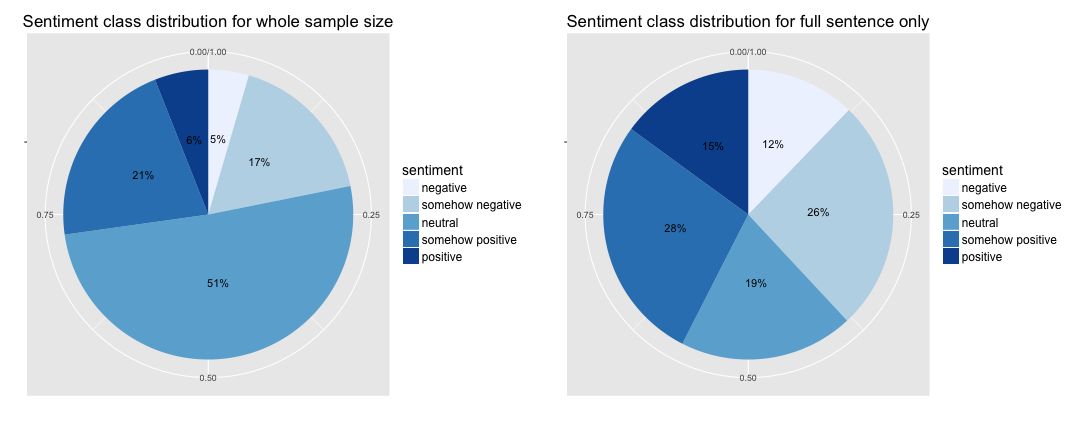

In [26]:
%%R -i cv_data,cv_sents_only -p 12 -w 15 -h 6 -u in
#ignore
library(ggplot2)
library(reshape2)
library(grid)
pie_plt <- function(df, title, ...){
    sentcls <- data.frame(table(df[['Sentiment']])/nrow(df));
    colnames(sentcls) <- c('sentiment','frequency');
    g <- ggplot(aes(x='', y=frequency, fill=sentiment), data = sentcls) + geom_bar(stat="identity", width = 1) +
    scale_fill_brewer(labels = c("negative", "somehow negative", "neutral", "somehow positive", "positive")) + 
    coord_polar(theta = "y") + xlab("") + ylab("") + geom_text(aes(x = '', y = cumsum(frequency) - frequency/2, 
            hjust = 0.6, vjust = 0, label = paste0(format(frequency*100, digits = 1), "%"))) + labs(title = title) + 
    theme(title=element_text(size=14), legend.text=element_text(size=12));
    return(g);
}
vplayout <- function(x, y) viewport(layout.pos.row = x, layout.pos.col = y);
grid.newpage();
pushViewport(viewport(layout = grid.layout(1,2)));
print(pie_plt(cv_data, 'Sentiment class distribution for whole sample size'), 
      vp = vplayout(1,1))
print(pie_plt(cv_sents_only, 'Sentiment class distribution for full sentence only'),
     vp = vplayout(1,2))

In [ ]:
from numpy.random import binomial
n, p, m = 1000, 0.98, 1; # binomial parameters n, p and m times simulations
N = binomial(n, p, m);
y = np.zeros((m,n), dtype = np.int);
num_cv = 10;
for i in range(m):
    y[i,0:N[i]] = 1;
    toykfolder = KFold(n, n_folds = num_cv, shuffle = True);
    toyskfolder = StratifiedKFold(y[i], n_folds = num_cv, shuffle = True);
    sent_dist = prepare_data(y[i], toykfolder, toyskfolder, cv_strategy, num_cv);

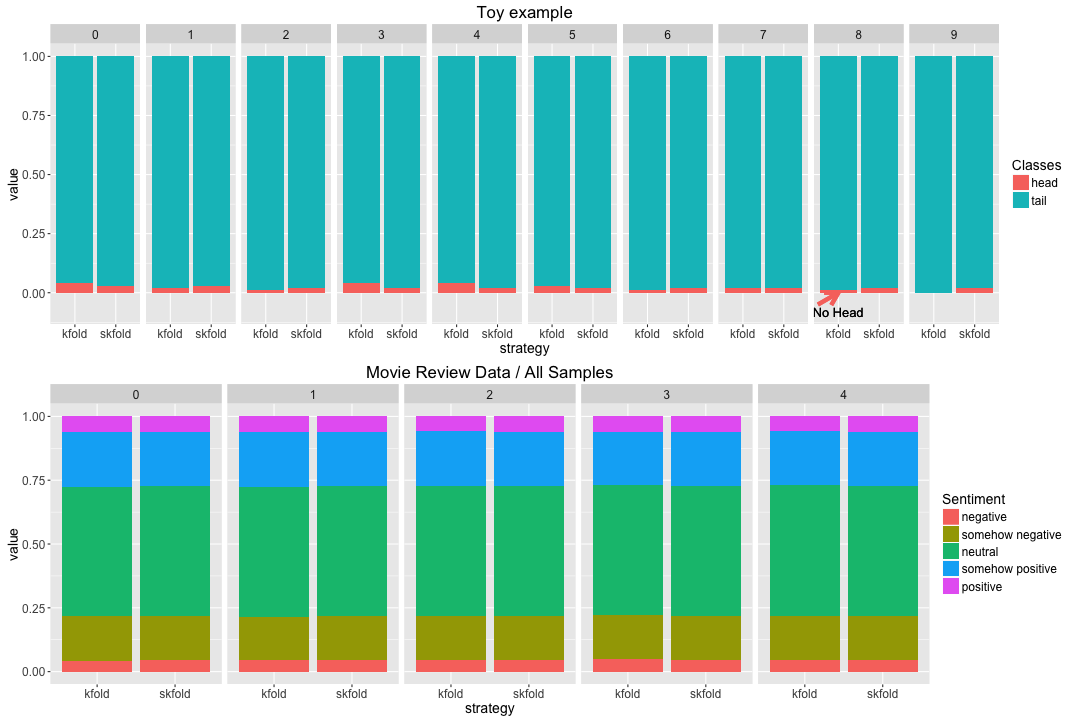

In [33]:
%%R -i sent_dist,movie_sent_dist -p 12 -w 15 -h 10 -u in
#ignore
library(ggplot2)
folds_plt<-function(df, title){
    df[,'Sentiment']<-as.factor(df[,'Sentiment']);
    g<-ggplot(aes(x = strategy, y = value, fill = Sentiment), data = df) + 
        geom_bar(position = 'fill', stat = 'identity') + 
        facet_grid('.~fold_num', labeller = label_bquote(.(paste0("k = ",x)))) + 
    labs(title = title) + theme(title=element_text(size=14), legend.text=element_text(size=12),
                                strip.text=element_text(size=12), axis.text=element_text(size=12));
    return(g);
}
grid.newpage();
pushViewport(viewport(layout = grid.layout(2,1)));
ann_text <- data.frame(strategy = gl(2, 1, labels = c("kfold","skfold")), 
                       Sentiment = gl(1, 2, labels = 0:4), fold_num = 8, value = c(0.0,0.0));
gt <- folds_plt(sent_dist, "Toy example") + scale_fill_discrete(name="Classes",labels = c("head", "tail")) +
geom_segment(aes(x = 0.5, y = -0.05, xend = 1, yend = 0, color = 'red'), data = ann_text, 
             arrow = arrow(length=unit(0.5, 'cm')), size = 2) + 
geom_text(aes(x = 1., y = -0.08, label='No Head', size = 2), data = ann_text) + guides(color=FALSE, size=FALSE)
print(gt, vp = vplayout(1,1))
gh <- folds_plt(movie_sent_dist, "Movie Review Data / All Samples") + 
scale_fill_discrete(labels = c("negative", "somehow negative", "neutral", "somehow positive", "positive"));
print(gh, vp = vplayout(2,1))

In [ ]:
#ignore
import matplotlib.pylab as plt 

is_discount_self = False;
sentpercent = trainer.cv_data.copy();
sentpercent['value'] = 1;
sentpercent = sentpercent.groupby(['SentenceId','Sentiment'])['value'].count();
#something wrong here, all training set contain phrases and the first Phrase might not be the sentnece
sentpercent = sentpercent.reset_index(level=1).merge(
    trainer.cv_data.groupby('SentenceId').nth(0)['Sentiment'].to_frame(), left_index = True, right_index = True);
sentpercent.columns = ['distribution', 'value', 'Sentiment'];
if is_discount_self:
    sentpercent.ix[sentpercent['distribution'] == sentpercent['Sentiment'],'value'] -=1;

sentpercent = sentpercent.reset_index();
sentpercent['value'] = sentpercent.groupby('SentenceId')['value'].transform(lambda x: x/x.sum());

But would it be a good idea to randomly split phrases without considering they are originally part of the full sentence? Let's examine the sentiment class distribution conditioning on each full sentence:
  
The below figure shows the pooling result of sentiment label distribution given the sentiment label of full sentences. Unsurprsingly, the dominating phrase label is the label identical to the one of full sentences. And the tendency of dominance decreases or increases when the sentiment label of full setences becomes more positive or negative. The correlation measured by Pearson $\chi^2$ shows this grouping is significantly not random. However, this is what we expect to see; otherwise, we would have difficulty to deduce sentiment of full sentence from its phrase compositions. But how strong using the composition of sentiment labels alone can infer the sentiment label of full sentence?  


	Pearson's Chi-squared test

data:  freq_tbl
X-squared = 3813.2, df = 16, p-value < 2.2e-16



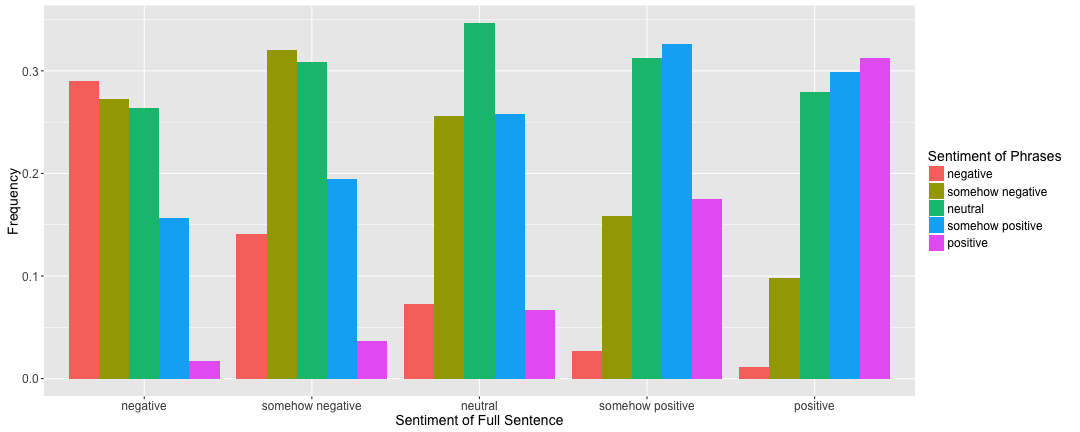

In [36]:
%%R -i sentpercent -p 12 -w 15 -h 6 -u in 
#ignore
library(ggplot2)
sentpercent[,'Sentiment'] <-as.factor(sentpercent[,'Sentiment']);
sentpercent[,'distribution'] <-as.factor(sentpercent[,'distribution']);
freq_tbl = table(sentpercent[,c('Sentiment','distribution')]);
print(chisq.test(freq_tbl))
freq_df <- as.data.frame(freq_tbl/rowSums(freq_tbl));
g1 <-ggplot(aes(x = Sentiment, y = Freq, fill = distribution), data = freq_df) + 
geom_bar(stat = 'identity', position = 'dodge')+ scale_fill_discrete(
    labels = c("negative", "somehow negative", "neutral", "somehow positive", "positive"), 
    name = "Sentiment of Phrases") + 
scale_x_discrete(labels = c("negative", "somehow negative", "neutral", "somehow positive", "positive"), 
    name = "Sentiment of Full Sentence") +  ylab("Frequency") + theme(title=element_text(size=14),
                                                                     legend.text=element_text(size=12),
                                                                     strip.text=element_text(size=12),
                                                                     axis.text=element_text(size=12));
print(g1)

Above figure is optimistic in a naive way: the individual phrase label distributions are grouped with the same sentiment class. It only shows the overall tendency when seeing the sentiment label of full sentence. However, each sentence has its own sentiment distribution for consisting phrases. If we plot sentiment distribution of phrases for each sentence, we should see multiple curves wide spread but centering at the location of each bar. I tried to nail down the relation of sentimet labels between full phrases and its member phrases in the following figure.  

You can treat the figure below as a matrix: the columns is the sentiment labels for full sentence and the rows are the sentiment labels for phrases. For each entry (i, j), it represents the histogram of the propotion phrase sentiment labels, i, given the sentiment of full sentence, j. The propotion ranging from 0 to 1, denoting the value in the x-axis in each entry, as the density as the value in the y-axis. If you sum along the row (or axis 0 in python numpy lingo), you will get the above figure.  And indeed, except the neutral sentiment class (numbered 2), the rest of sentiment labels have similar trends coincide with the above figure. You can see a small peak in the high proportion end if you look at the main diagonal from upper left to the lower right. This corraborates the above finding.   

Unfortunately, there is a prominent peak locating at low percentage also. This peak might address the close number for sentiment labels other than the one of full sentence in the above figure. One can see transition from one sentiment label to its close neighbor, such as negative to somehow negative or somehow positive to positive. This implies predicting the sentiment label of full sentence based on majority might be helpful in some cases but not most of them.   

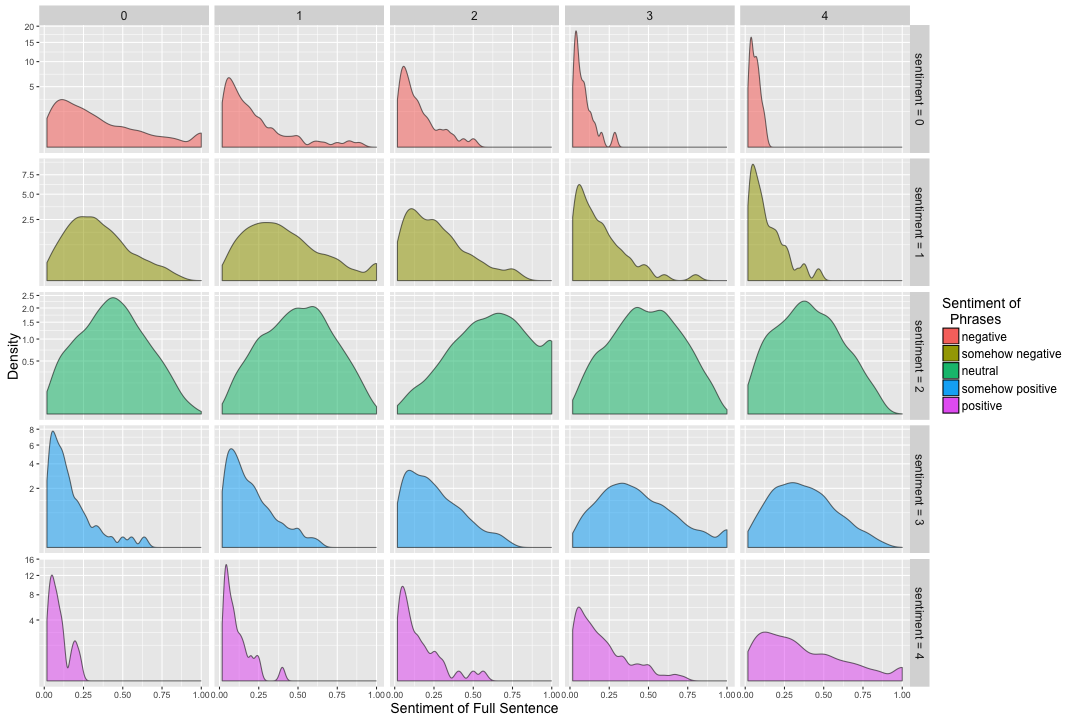

In [40]:
%%R -i sentpercent sentpercent -p 12 -w 15 -h 10 -u in
#ignore
# column is the sentiment class of a complete setence, row is the sentiment class distribution given the sentiment 
# class of complete setenece
sentpercent[,'Sentiment'] <-as.factor(sentpercent[,'Sentiment']);
sentpercent[,'distribution'] <-as.factor(sentpercent[,'distribution']);
g2 <-ggplot(aes(x = value, y = ..density.., fill = distribution, alpha = 0.3), data = sentpercent) + 
geom_density() + scale_y_sqrt(name='Density') + scale_fill_discrete(
    labels = c("negative", "somehow negative", "neutral", "somehow positive", "positive"), 
    name = "Sentiment of \n  Phrases") + 
    facet_grid('distribution~Sentiment', scales='free_y', labeller = label_bquote(.(paste0("sentiment = ",x)))) + 
    xlab("Sentiment of Full Sentence") + guides(alpha=FALSE) + theme(title=element_text(size=14),
                                                                     legend.text=element_text(size=12),
                                                                     strip.text=element_text(size=12))
                                    
print(g2)

This figure poses an alternative view from figure 2 in Socher et al.'s study ([Socher, 2013](http://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)). 
In their figure, they showed distribution of sentiment labels conditioning on N-gram instead of sentiment labels of full sentence. You could draw a line (the upper yellow dashed one) across the high percentage region and the other across the low percentage as corresponding to the two peaks in above figure. And realized that the prominent peak in the above figure might mainly consist shorter phrases or smaller N where neutral sentiment label dominates (as you could see the porminent peak in the neutral labels is acutally not locating low percentagle but somewhere medium close to 0.5). This observation contradicts against the intution in Pang & Lee' s paper ([Pang &amp; Lee, 2013](http://www.cs.cornell.edu/home/llee/papers/pang-lee-stars.pdf)). They proposed the idea by using regression to capture the continuity for sentiment rating. However, roughly counting positive-sentence percentage as they proposed will not count in the effect of transitional phrases such as high level negation and contrastive as captured by Socher et al's parsing tree method. Some non-deterministic factor related to random assignment of neutral sentiment should be counted in as well. 
    
Another trivial point is that unbalance data will no longer a problem for training for larger N as they distributes almost uniformly. Based on the big data principle and for the sake of saving all potential training examples, a more sophiscated training scheme might be needed. Would the popular deep learning give a helpful hand?  
   
*More Later!*

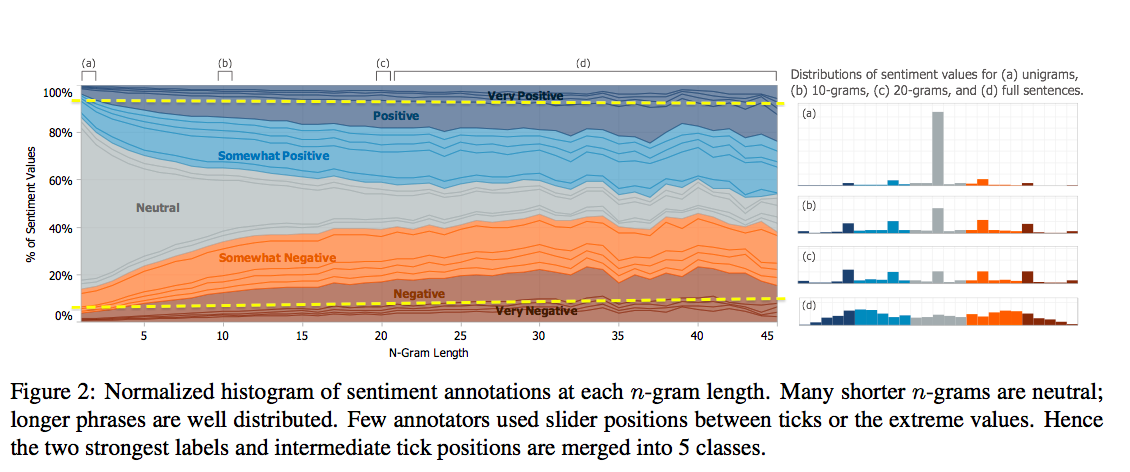

In [41]:
#ignore
from IPython.display import Image
Image(filename='/Users/renewang/Documents/workspace/Kaggle/WorkNote/LoP_draft/image/Socher_EMNLP2013_fig2.png')